# tree sequence workshop- Part 3: Inference

### Friday 14 December

Welcome to the tree sequence workshop. Today we will give you an overview of the tree sequence data structure, the $\texttt{msprime}$ coalescent simulator, and our efficient inference framework: $\texttt{tsinfer}$. 

# Contents

0. [Import](#import)
1. [Inferring tree sequences (tsinfer)](#tsinfer)
2. [Metadata](#metadata)
3. [References and Documentation](#ref)

<a id='import'></a>
# 0. Import


In [6]:
import numpy as np
from IPython.display import SVG, display
import pandas as pd

import msprime #NB some functions here e.g. msprime.load() will change soon to tskit.load()
import tsinfer

/Users/anthonywohns/anaconda_ete/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/anthonywohns/anaconda_ete/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


<a id='tsinfer'></a>
# 4. Genealogical inference

Simulating a tree sequence is relatively simple compared to *inferring* a tree sequence from existing data. The [`tsinfer` software](https://tsinfer.readthedocs.io/en/latest/) (pronounced T. S. Infer), currently in active development, implements a heuristic algorithm which does this in a scalable manner.

`Tsinfer` is comparable in some ways to other ancestral inference software such as [ARGweaver](https://doi.org/10.1371/journal.pgen.1004342), [Relate](https://myersgroup.github.io/relate/), and [Rent+](https://doi.org/10.1093/bioinformatics/btw735). However, it differs considerably in approach and scalability. Note that none of these other software packages produce tree sequences as output, although is possible (but unsupported and tedious) to convert their output to tree sequences. Also note that `tsinfer` produces trees with a relatively accurate topology, but unlike other ancestral inference tools, makes no attempt at the moment to produce precise branch length estimates.

## Algorithm details

The best current description of `tsinfer` in the [preprint on Biorxiv](https://www.biorxiv.org/content/early/2018/11/01/458067).

The key `tsinfer`'s scalability is that, rather than compare sample genomes with each other in a pairwise manner, we use them to reconstruct the genomic sequence of their **ancestors**. These ancestors can consist of partial chunks of sequence, since we know that the older the ancestor, the shorter the inherited chunks (or "ancestral haplotypes") are likely to be.

If we have reasonably estimated ancestral haplotypes (and a rough age order) we can take advantage of a modified version of the Li & Stephens matching algorithm to calculate which ancestors immediately descend (or "copy") from which others. Once we have done this, we can apply the same method to deduce from which ancestors the current samples descend. This obviates the need to make pairwise comparisons between samples, which is computationally extortionate.

The "copying order" created during the matching process directly corresponds to the edges in a tree sequence (in fact, the tree sequence format is created during the matching process, and tree sequence technology is integral to the fast performance of the matching algorithm).

With simulation, we can show that with ideal ancestors

The `tsinfer` method is split into two main parts: (1) the reconstruction and time ordering of ancestral haplotypes and (2) the inference of the copying process. Via simulation, we can show that using "perfect ancestors" in the copying process results in perfect inference of the copying process. Thus, although part (2) is the most technically challenging part of the algorithm, we suspect that most inaccuracy in our algorithm can be traced to assumptions and simplifications made in part (1). For this reason we mainly focus on the details of ancestral haplotype reconstruction and ordering.

The preprint contains the following schematic overview of the method:

Figure 2b:<img src="images/tsinfer-schematic.png">

### Part 1: Ancestor reconstruction

heuristic (plot of Fig S2) plus assumptions
Age order assumptions

### Part 2: Copying path inference
Some detail about Li & Stephens here

Some detail about path compression.

Note that it may not matter (apart from for performance) if we reconstruct ancestors in part (1) that are too long

### Inference accuracy
There are no established ways to compare one tree sequence (or ARG)

## tsinfer Example
Let's start by using the variation data from the tree sequence we simulated above to infer the tree. We use the VCF file that we saved earlier and convert it to a sample_data object.

In [ ]:
threepop_sim = msprime.load("data/threepop_sim.ts")

In [3]:
with tsinfer.SampleData(
        path="simulation.samples", sequence_length=simulation.sequence_length,
        num_flush_threads=2) as sample_data:
    for var in simulation.variants():
        sample_data.add_site(var.site.position, var.genotypes, var.alleles)
sample_data.finalise()

NameError: name 'simulation' is not defined

In [0]:
inferred_ts = tsinfer.infer(sample_data)
tables = inferred_ts.dump_tables()
tables.nodes.set_columns(flags=np.ones(inferred_ts.get_num_nodes(),dtype=np.uint32),time=tables.nodes.time) 
inferred_ts_all_nodes = msprime.TableCollection.tree_sequence(tables)

In [0]:
for tree in inferred_ts.trees():
    display(SVG(tree.draw(width=800,height=500)))
    print(tree.get_interval())
    

## Vivax Example

We now use tsinfer on real data from the [ *P. vivax* Genome Variation Project](https://www.malariagen.net/projects/p-vivax-genome-variation) containing 228 samples from 13 countries. Joe Zhu ran [Deploid](https://github.com/DEploid-dev/DEploid) on this dataset to identify 124 clonal samples. He then phased and imputed haplotypes for each strain.
<br> 
Since $\texttt{tsinfer}$ requires ancestral and derived alleles, Wilder used [$\texttt{Mauve}$](http://darlinglab.org/mauve/mauve.html) to create a multi-species alignment of the *vivax* genome to outgroups *cynomolgi* ([a sister taxon of *vivax*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759362/))and *knowlesi* (an outgroup of *vivax* and *cynomolgi* ).  A rules-based maximum parsimony approach was used to determine ancestral alleles using this multi-species alignment. Ancestral alleles were only called where the reference call at all three species agreed.
<br>
We have pre-made a SampleData object that $\texttt{tsinfer}$ requires to run of the 124 vivax samples to avoid going over the details of working with VCFs.

In [23]:
vivax_sample_data = tsinfer.load("data/clonal_vivax.samples")
vivax_inferred_ts = tsinfer.infer(vivax_sample_data)

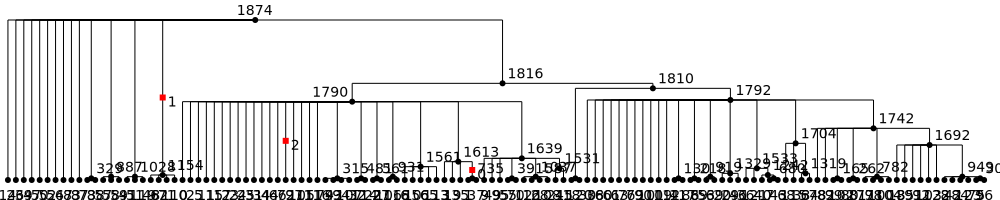

In [28]:
SVG(vivax_inferred_ts.first().draw(width=1000))

<a id='metadata'></a>
# 6. Storing metadata in tree sequences

Methods are provided to store and retrieve structured as well as arbitrary metadata associated with a tree sequence. For example, individuals might have meaningful names or geographic locations. Another example of this is [provenance information](https://msprime.readthedocs.io/en/stable/provenance.html), which tells you how the tree sequence was generated. For example, for simulated data, it details the computer the simulation was run on, the simulation parameters, etc.

In [15]:
import json # arbitrary metadata tends to use JSON formatting

print("\n== main_tree_seq ==")
for p in main_tree_seq.provenances():
  rec = json.loads(p.record)
  print("> Simulated using software:", rec['software'],
       "\n> with parameters", rec['parameters'])

print("\n== ts_fwdsim ==")
for p in ts_fwdsim.provenances():
  rec = json.loads(p.record)
  print("> Simulated using software:", rec['software'],
       "\n> using command", rec['parameters']['command'],
       "\n> Eidos script was:", rec['parameters']['model'])



== main_tree_seq ==


NameError: name 'main_tree_seq' is not defined

For inferred tree sequences, metadata is intended to store the source (i.e. geographical) of the sequence data.
<br>
For our vivax example, we know the country of origin of the 124 sequences we are considering, so we can add this provenance information. 

<a id='ref'></a>
# 5. References and Documentation

$\texttt{msprime}$: <br>
Reference: Kelleher, J., Etheridge, A.M. and McVean, G., 2016. Efficient coalescent simulation and genealogical analysis for large sample sizes. PLoS computational biology, 12(5), p.e1004842.
<br>
Documentation: https://msprime.readthedocs.io/en/stable/index.html

$\texttt{SLiM}$: <br>
Reference: Haller, B.C., Galloway, J., Kelleher, J., Messer, P.W. and Ralph, P.L., 2018. Tree‐sequence recording in SL iM opens new horizons for forward‐time simulation of whole genomes. Molecular Ecology Resources.
<br>
Documentation: http://benhaller.com/slim/SLiM_Manual.pdf

$\texttt{tsinfer}$: <br>
Reference:  Kelleher, J., Wong, Y., Albers, P., Wohns, A.W. and McVean, G., 2018. Inferring the ancestry of everyone. bioRxiv, p.458067.
<br>
Documentation: https://tsinfer.readthedocs.io/en/latest/api.html?highlight=sample_data

Out of Africa Model used in section 3: <br>
Gutenkunst, R.N., Hernandez, R.D., Williamson, S.H. and Bustamante, C.D., 2009. Inferring the joint demographic history of multiple populations from multidimensional SNP frequency data. PLoS genetics, 5(10), p.e1000695.